In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np  
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Add
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import PReLU
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [3]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
import librosa
import numpy as np

def to_melspectrogram(signal, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(y=x, sr=44100, n_fft=n_fft,
                                                       hop_length=hop_length, n_mels=128)[:, :, np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, signal)
    return np.array(list(tsongs))


In [6]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convert each audio file to spectrograms and split into small windows
    for file_path, genre in zip(X, y):
        try:
            # Load the audio file
            signal, sr = librosa.load(file_path)
            signal = signal[:song_samples]

            # Split the audio signal into small windows and associate with genre labels
            signals, genres = splitsongs(signal, genre)

            # Convert to mel spectrogram representation
            spectrograms = to_melspectrogram(signals)

            # Save the results
            arr_genres.extend(genres)
            arr_specs.extend(spectrograms)

        except Exception as e:
            print(f"Error processing audio file {file_path}: {e}")

    return np.array(arr_specs), to_categorical(arr_genres)


In [7]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [8]:
# Parameters
gtzan_dir = 'genres_original/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

C:\Users\AENUGU TEJA SWAROOP\AppData\Local\Temp\ipykernel_21912\3196869414.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path)
c:\xampp\htdocs\Data\myenv\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing audio file genres_original/jazz/jazz.00054.wav: 


In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27300, 128, 129, 1) (11661, 128, 129, 1) (27300, 10) (11661, 10)


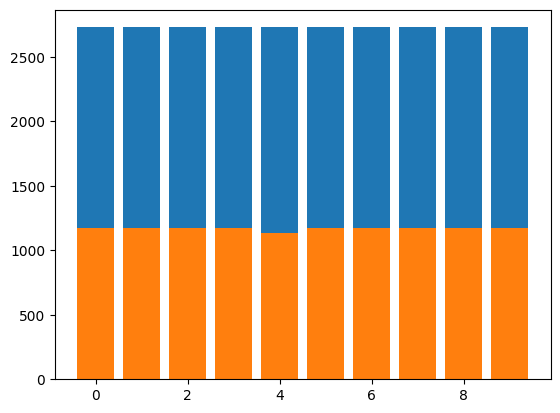

In [10]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# GTZAN Melspectrogram Generator

In [11]:
from keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

# Custom CNN (Melspectrogram version)

In [12]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [13]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 32)  # Increased the initial number of filters
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    x = conv_block(x, 512)  # Added another convolutional layer
    
    # Global Pooling and MLP
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [14]:
model = create_model(X_train[0].shape, len(genres))

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 129, 32)      320       
                                                                 
 activation (Activation)     (None, 128, 129, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                             

### Loss function

In [16]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjusted learning rate
              metrics=['accuracy'])

In [17]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [18]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [19]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=200,  # Increased the number of epochs
    verbose=1,
    callbacks=[reduceLROnPlat])

C:\Users\AENUGU TEJA SWAROOP\AppData\Local\Temp\ipykernel_21912\3998605792.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/200


214/214 [==============================] - 164s 756ms/step - loss: 9.8049 - accuracy: 0.1292 - val_loss: 4.1813 - val_accuracy: 0.1636 - lr: 0.0010
Epoch 2/200
214/214 [==============================] - 162s 756ms/step - loss: 3.1624 - accuracy: 0.1655 - val_loss: 2.6088 - val_accuracy: 0.1467 - lr: 0.0010
Epoch 3/200
214/214 [==============================] - 166s 777ms/step - loss: 2.4117 - accuracy: 0.1961 - val_loss: 2.2440 - val_accuracy: 0.2252 - lr: 0.0010
Epoch 4/200
214/214 [==============================] - 165s 771ms/step - loss: 2.2665 - accuracy: 0.1833 - val_loss: 2.2268 - val_accuracy: 0.1889 - lr: 0.0010
Epoch 5/200
214/214 [==============================] - 164s 768ms/step - loss: 2.1984 - accuracy: 0.1787 - val_loss: 2.2024 - val_accuracy: 0.1763 - lr: 0.0010
Epoch 6/200
214/214 [==============================] - 174s 814ms/step - loss: 2.1498 - accuracy: 0.2130 - val_loss: 2.0648 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 7/200
214/214 [=================

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.948 and val_acc = 0.729


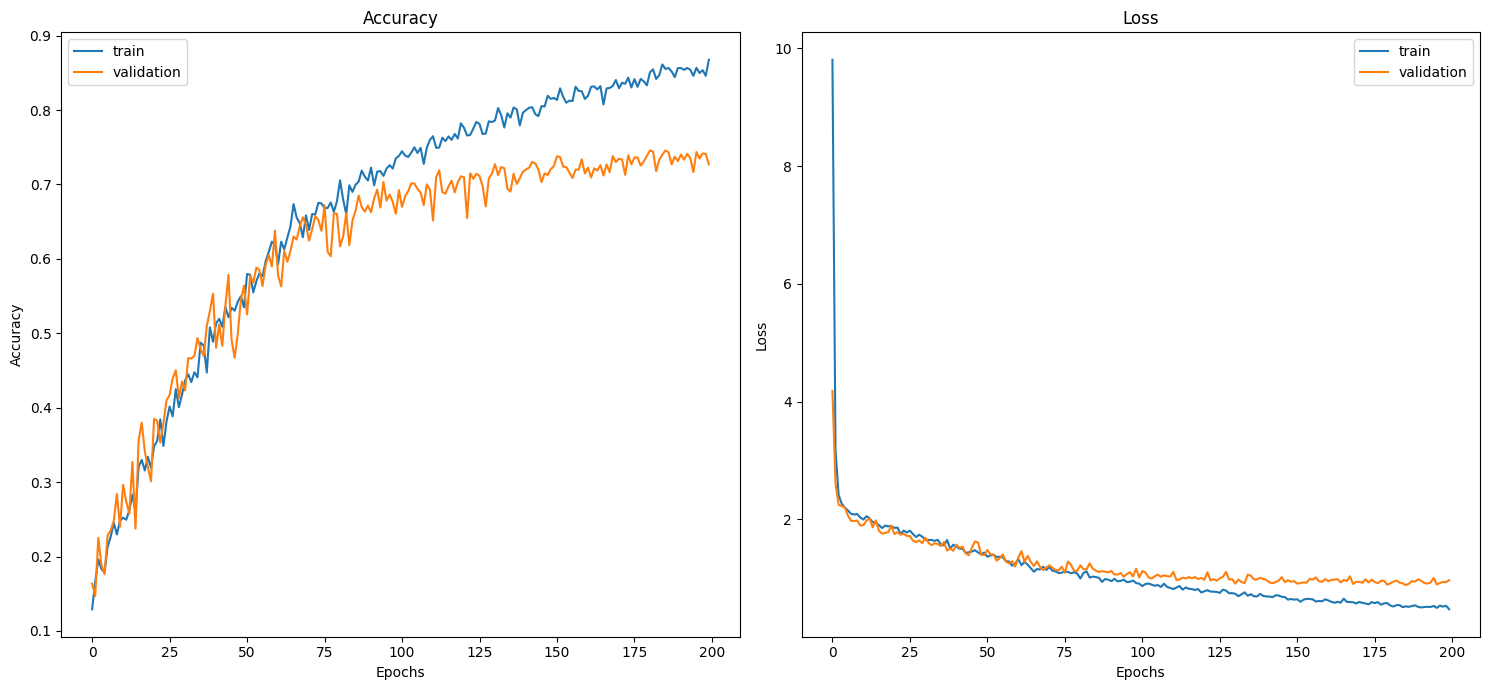

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

365/365 [==============================] - 35s 93ms/step


Normalized confusion matrix


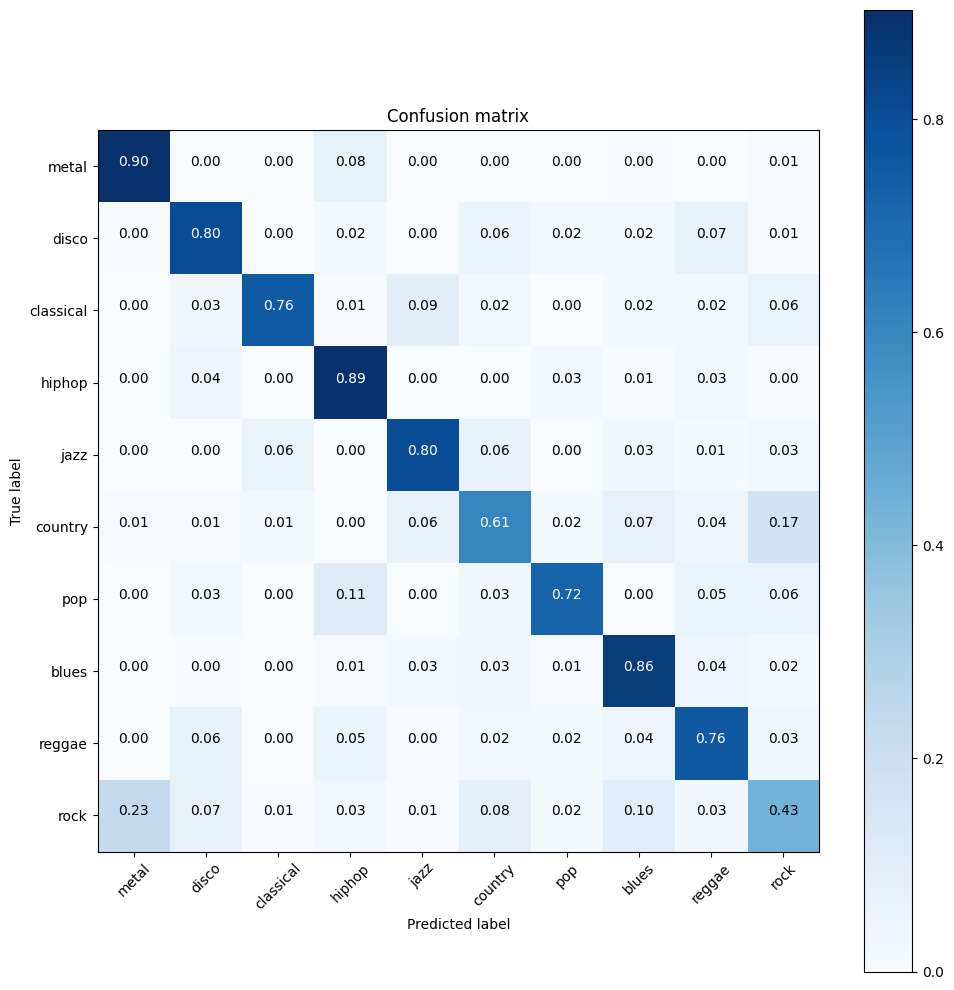

In [24]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)


## Majority Vote

In [25]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [26]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [27]:
# Each sound was divided into 39 segments in our custom function
print(preds.shape)

# Reshape 'preds' to (number_of_sounds, 39, number_of_classes)
preds_reshaped = preds.reshape(-1, 39, preds.shape[1])

# Perform majority voting on predictions
predicted_labels = np.argmax(np.sum(preds_reshaped, axis=1), axis=1)

(11661, 10)


In [28]:
# Reshape 'y_test' to (number_of_sounds, 39, number_of_classes)
y_test_reshaped = y_test.reshape(-1, 39, y_test.shape[1])

# Perform majority voting on true labels
true_labels = np.argmax(np.sum(y_test_reshaped, axis=1), axis=1)

In [29]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Majority voting system (acc) = {:.3f}".format(accuracy))

Majority voting system (acc) = 0.806


## Save the model

In [30]:
# Save the model
model.save('custom_cnn_2d_v2.h5')

c:\xampp\htdocs\Data\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
